In [160]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.circuit.library import MCXGate, QFT
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

In [161]:
def u_init() -> QuantumCircuit:
    theta_0 = 0.2
    theta_1 = 1.6
    qc = QuantumCircuit(2)
    qc.ry(theta_0, 0)
    qc.ry(theta_1, 1)
    return qc

In [162]:
def a_unitary() -> QuantumCircuit:
    qc = QuantumCircuit(3)
    qc = qc.compose(u_init(), [0, 1])
    qc.append(MCXGate(2, ctrl_state="10"), [0, 1, 2])
    return qc

In [163]:
a_dagger = a_unitary().inverse()

In [164]:
def s_b0_unitary():
    # S_B0 = 2|B>|0><B|<0|-I = Z * I * I
    # Geometrically, this unitary changes theta to -theta, negating the 
    # amplitude in front of |G>|1>, which is produced by applying a Z gate.
    qc = QuantumCircuit(3)
    qc.z(2)
    return qc

In [165]:
def q_unitary() -> QuantumCircuit:
    q = QuantumCircuit(3)
    
    q = q.compose(s_b0_unitary(), [0, 1, 2])
    q = q.compose(a_dagger, [0, 1, 2])
    
    # S_0 = 2|000><000|-I
    unitary = [[1, 0, 0, 0, 0, 0, 0, 0], 
               [0, -1, 0, 0, 0, 0, 0, 0],
               [0, 0, -1, 0, 0, 0, 0, 0],
               [0, 0, 0, -1, 0, 0, 0, 0],
               [0, 0, 0, 0, -1, 0, 0, 0],
               [0, 0, 0, 0, 0, -1, 0, 0],
               [0, 0, 0, 0, 0, 0, -1, 0],
               [0, 0, 0, 0, 0, 0, 0, -1]]
    q.unitary(unitary, [0, 1, 2])
    
    q = q.compose(a_unitary(), [0, 1, 2])
    return q

In [166]:
def qft_dagger(qc, n):
    # Applies inverse QFT on the first n qubits
    for i in range(n):  
        for j in range(i):
            qc.cp(-np.pi/(2**(i-j)),n-j-1,n-i-1)
        qc.h(n-i-1)

In [167]:
def amplitude_estimation(eval_bits: int = 3) -> QuantumCircuit:
    num_qubits = eval_bits + 3 # + 3 for |psi>
    est = QuantumCircuit(eval_bits + 3, eval_bits) 
    est = est.compose(a_unitary(), range(num_qubits - 3, num_qubits))
    
    est.h(range(0, eval_bits))
    
    q_controlled = q_unitary().to_gate().control()
    
    for i in range(eval_bits, 0, -1):
        for x in range(2 ** (i-1)):
            est.append(q_controlled, [i-1] + list(range(eval_bits, num_qubits)))
    qft_dagger(est, eval_bits)
    
    for i in range(eval_bits):
        est.measure(i, i)
    
    return est

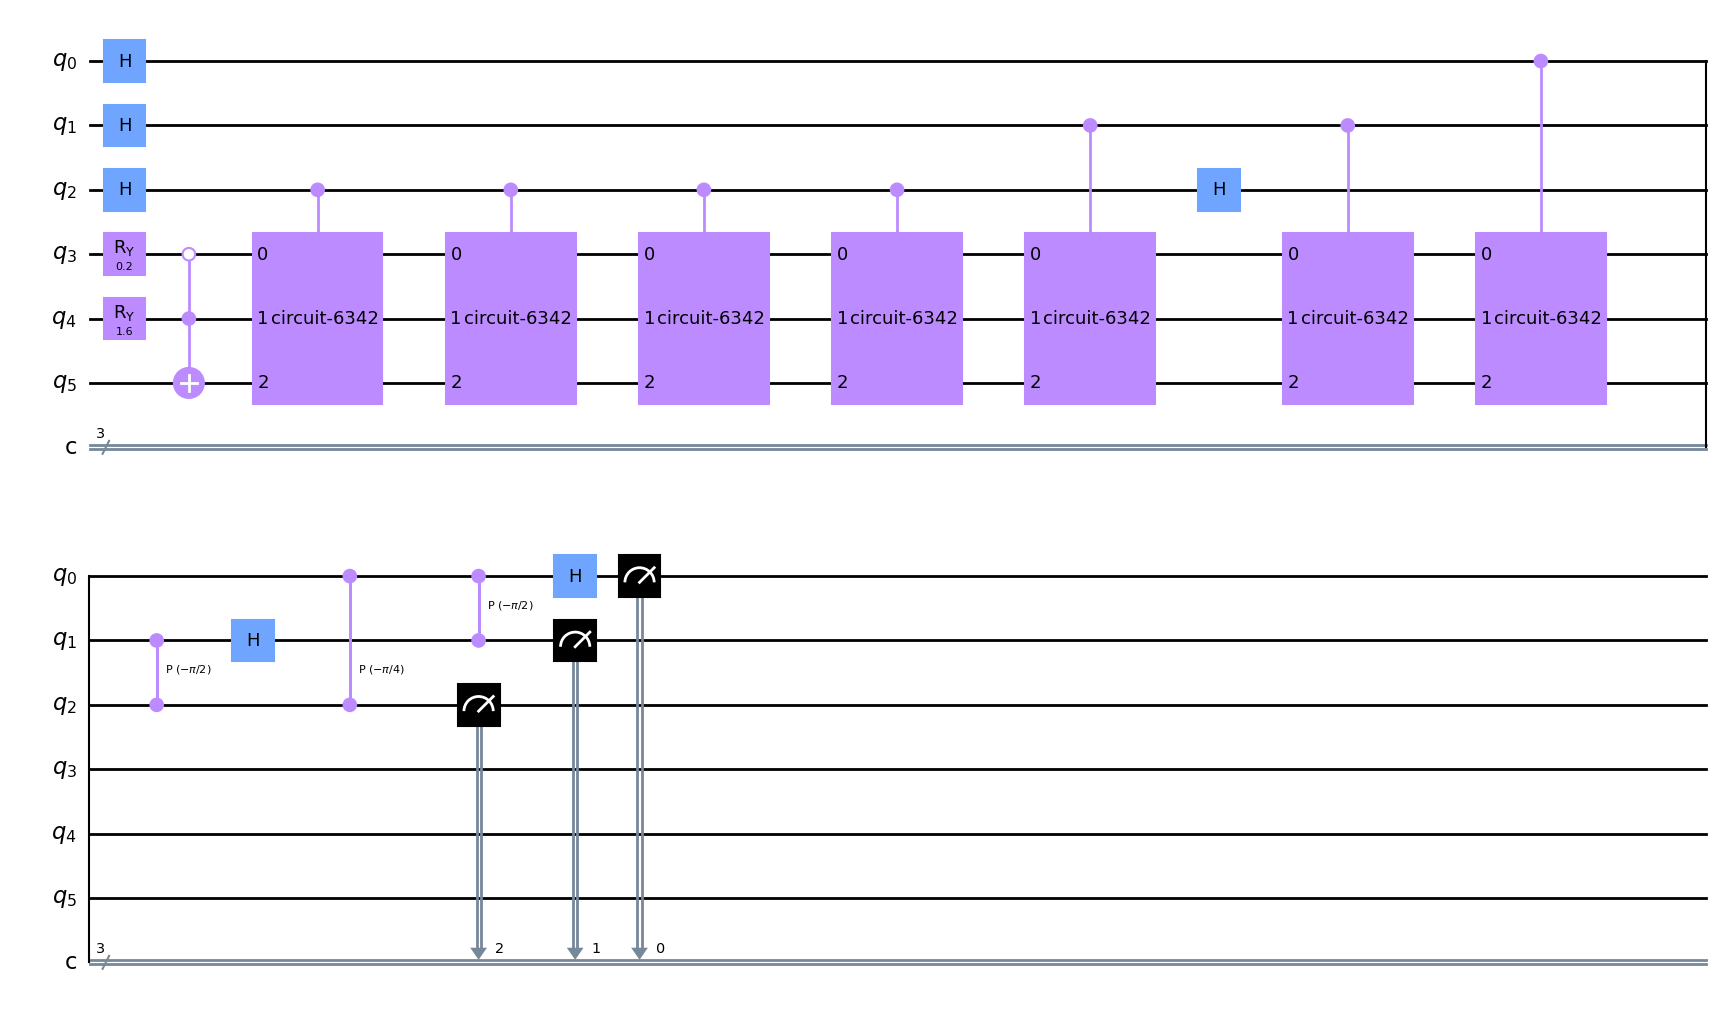

In [168]:
circuit = amplitude_estimation()
circuit.draw()

{'100': 1, '101': 2, '110': 5, '001': 3, '000': 1, '010': 4118, '111': 3, '011': 4059}


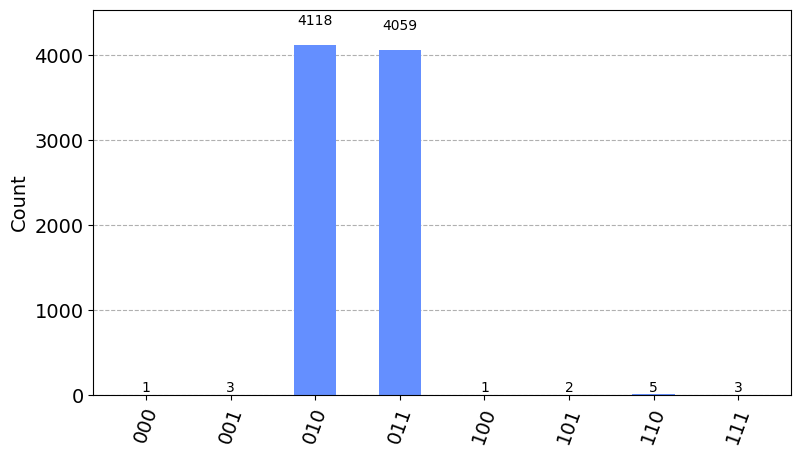

In [171]:
sim = Aer.get_backend("aer_simulator")
shots = 8192
counts = execute(circuit, sim, shots=shots).result().get_counts()
print(counts)
plot_histogram(counts, figsize=(9,5))

In [190]:
for key, value in counts.items():
    s = 0
    v = -1
    
    for c in key[::-1]: # key should be read right-to-left due to Qiskit's little endian notation
        s += int(c) * (2 ** (v))
        v -= 1
    print(f"Amplitude {np.sin(s * np.pi)} appeared with {100 * value/shots} probability.")

Amplitude 0.3826834323650898 appeared with 0.01220703125 probability.
Amplitude 0.9238795325112867 appeared with 0.0244140625 probability.
Amplitude 0.9238795325112867 appeared with 0.06103515625 probability.
Amplitude 1.0 appeared with 0.03662109375 probability.
Amplitude 0.0 appeared with 0.01220703125 probability.
Amplitude 0.7071067811865475 appeared with 50.2685546875 probability.
Amplitude 0.3826834323650899 appeared with 0.03662109375 probability.
Amplitude 0.7071067811865476 appeared with 49.54833984375 probability.
